In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Top 10 words for Ham:
u: 979
gt: 318
lt: 316
get: 301
go: 248
ok: 245
got: 242
ur: 237
know: 236
like: 231

Top 10 bigrams for Ham:
lt gt: 276
gon na: 58
call later: 50
let know: 39
sorry call: 38
r u: 37
u r: 35
good morning: 31
take care: 31
u wan: 29

Top 10 trigrams for Ham:
sorry call later: 38
lt decimal gt: 23
gt lt gt: 18
happy new year: 18
lt gt lt: 16
like lt gt: 14
pls send message: 13
cant pick phone: 12
pick phone right: 12
phone right pls: 12


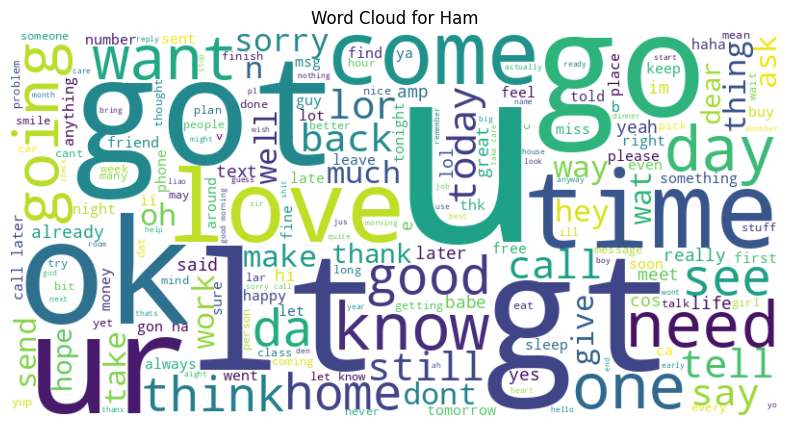


Top 10 words for Spam:
call: 346
free: 219
txt: 156
ur: 144
u: 141
mobile: 123
text: 121
stop: 114
claim: 113
reply: 104

Top 10 bigrams for Spam:
please call: 45
po box: 24
guaranteed call: 23
prize guaranteed: 22
call landline: 22
selected receive: 19
send stop: 19
every week: 19
await collection: 19
call claim: 18

Top 10 trigrams for Spam:
prize guaranteed call: 21
call land line: 18
private account statement: 16
call identifier code: 15
guaranteed call land: 15
identifier code expires: 14
land line claim: 14
draw shows prize: 13
shows prize guaranteed: 13
account statement shows: 13


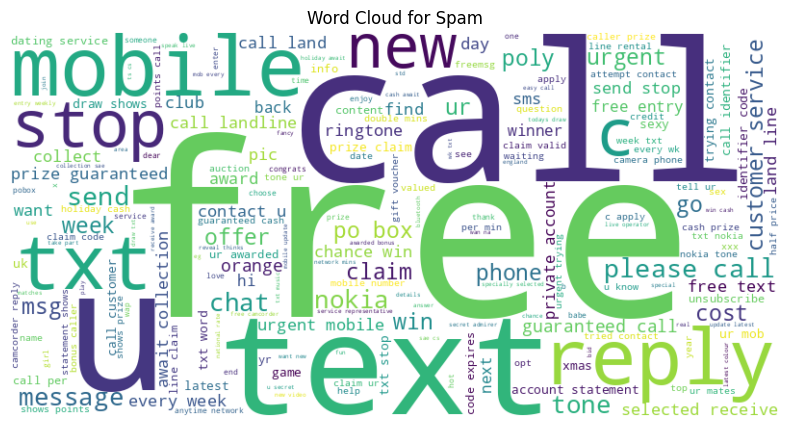


F1-score for Bag-of-Words: 0.9091
F1-score for TF-IDF: 0.7905
F1-score for TF-IDF with Preprocessing: 0.7760

Summary of F1-scores:
Bag-of-Words: 0.9091
TF-IDF: 0.7905
TF-IDF with Preprocessing: 0.7760


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only label and text columns
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text for EDA
def preprocess_for_eda(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

# Function to get n-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# EDA: Most frequent words, bigrams, trigrams
def perform_eda(df, class_label, class_name):
    class_texts = df[df['label'] == class_label]['text']
    all_tokens = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        all_tokens.extend(tokens)
    
    # Most frequent words
    word_counts = Counter(all_tokens)
    print(f"\nTop 10 words for {class_name}:")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    # Most frequent bigrams
    bigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        bigrams.extend(get_ngrams(tokens, 2))
    bigram_counts = Counter(bigrams)
    print(f"\nTop 10 bigrams for {class_name}:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"{' '.join(bigram)}: {count}")
    
    # Most frequent trigrams
    trigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        trigrams.extend(get_ngrams(tokens, 3))
    trigram_counts = Counter(trigrams)
    print(f"\nTop 10 trigrams for {class_name}:")
    for trigram, count in trigram_counts.most_common(10):
        print(f"{' '.join(trigram)}: {count}")
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()

# Perform EDA for ham and spam
perform_eda(df, 0, 'Ham')
perform_eda(df, 1, 'Spam')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# 1. Bag-of-Words Model
bow_vectorizer = CountVectorizer(stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Train and evaluate model
model = LogisticRegression(random_state=42)
model.fit(X_train_bow, y_train)
y_pred_bow = model.predict(X_test_bow)
f1_bow = f1_score(y_test, y_pred_bow)
print(f"\nF1-score for Bag-of-Words: {f1_bow:.4f}")

# 2. TF-IDF Model
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and evaluate model
model.fit(X_train_tfidf, y_train)
y_pred_tfidf = model.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)
print(f"F1-score for TF-IDF: {f1_tfidf:.4f}")

# 3. TF-IDF with Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove email IDs, URLs, HTML tags, numbers, punctuation
    text = re.sub(r'\S+@\S+', '', text)  # Email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'<.*?>', '', text)  # HTML tags
    text = re.sub(r'\d+', '', text)  # Numbers
    text = re.sub(r'[^\w\s]', '', text)  # Punctuation
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]
    return ' '.join(tokens)

# Apply preprocessing
X_train_preprocessed = X_train.apply(preprocess_text)
X_test_preprocessed = X_test.apply(preprocess_text)

# TF-IDF on preprocessed text
X_train_tfidf_pre = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf_pre = tfidf_vectorizer.transform(X_test_preprocessed)

# Train and evaluate model
model.fit(X_train_tfidf_pre, y_train)
y_pred_tfidf_pre = model.predict(X_test_tfidf_pre)
f1_tfidf_pre = f1_score(y_test, y_pred_tfidf_pre)
print(f"F1-score for TF-IDF with Preprocessing: {f1_tfidf_pre:.4f}")

# Summary of F1-scores
print("\nSummary of F1-scores:")
print(f"Bag-of-Words: {f1_bow:.4f}")
print(f"TF-IDF: {f1_tfidf:.4f}")
print(f"TF-IDF with Preprocessing: {f1_tfidf_pre:.4f}")

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Top 10 words for Ham:
u: 979
gt: 318
lt: 316
get: 301
2: 300
go: 248
ok: 245
got: 242
ur: 237
know: 236

Top 10 bigrams for Ham:
lt gt: 276
gon na: 58
call later: 50
let know: 39
sorry call: 38
r u: 37
u r: 35
good morning: 31
take care: 31
wan 2: 31

Top 10 trigrams for Ham:
sorry call later: 38
lt decimal gt: 23
u wan 2: 21
happy new year: 18
gt lt gt: 17
lt gt lt: 15
like lt gt: 14
pls send message: 13
cant pick phone: 12
pick phone right: 12


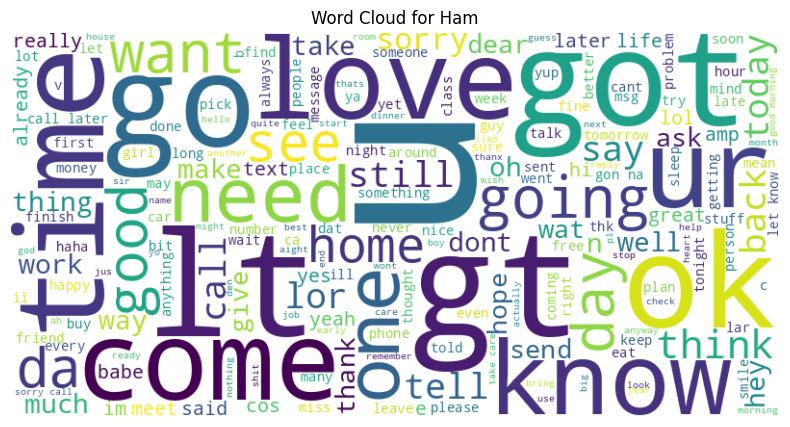


Top 10 words for Spam:
call: 346
free: 219
2: 174
txt: 156
ur: 144
u: 141
mobile: 123
text: 121
4: 120
stop: 114

Top 10 bigrams for Spam:
please call: 45
po box: 24
guaranteed call: 23
prize guaranteed: 22
send stop: 19
every week: 19
await collection: 19
urgent mobile: 18
land line: 18
customer service: 17

Top 10 trigrams for Spam:
prize guaranteed call: 21
reply call 08000930705: 14
land line claim: 14
draw shows prize: 13
shows prize guaranteed: 13
private 2003 account: 13
2003 account statement: 13
camcorder reply call: 12
shows 800 points: 12
800 points call: 12


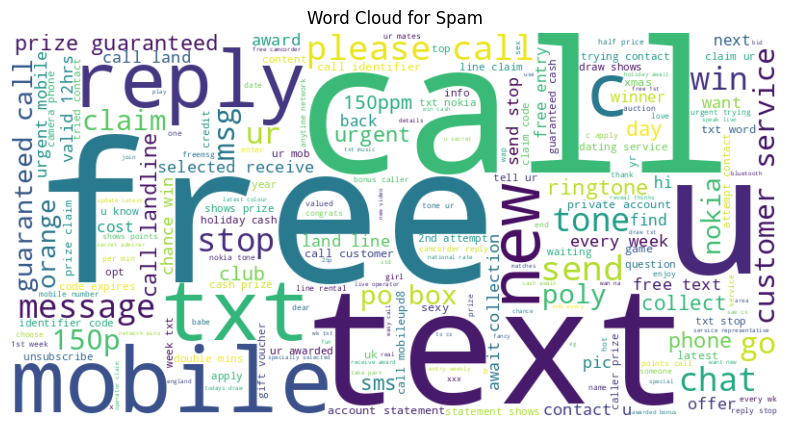


F1-score for Bag-of-Words (tuned): 0.9143
BoW Cross-validation F1-scores: 0.9192 ± 0.0233


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (tuned): 0.9078


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

TF-IDF Cross-validation F1-scores: 0.8918 ± 0.0263
F1-score for Naive Bayes (BoW): 0.9333
Naive Bayes Cross-validation F1-scores: 0.8989 ± 0.0205


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

F1-score for SVM (TF-IDF): 0.9268


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


SVM Cross-validation F1-scores: 0.9120 ± 0.0314

Summary of F1-scores:
BoW (Logistic Regression): 0.9143
TF-IDF (Logistic Regression): 0.9078
BoW (Naive Bayes): 0.9333
TF-IDF (SVM): 0.9268


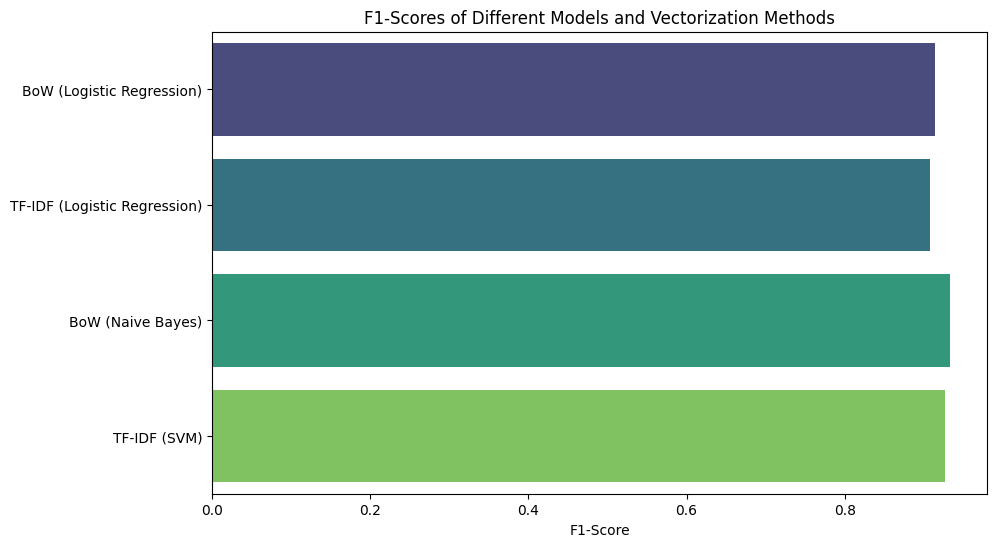

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import seaborn as sns
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only label and text columns
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text for EDA
def preprocess_for_eda(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]  # Keep alphanumeric (words and numbers)
    return tokens

# Function to get n-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# EDA: Most frequent words, bigrams, trigrams
def perform_eda(df, class_label, class_name):
    class_texts = df[df['label'] == class_label]['text']
    all_tokens = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        all_tokens.extend(tokens)
    
    # Most frequent words
    word_counts = Counter(all_tokens)
    print(f"\nTop 10 words for {class_name}:")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    # Most frequent bigrams
    bigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        bigrams.extend(get_ngrams(tokens, 2))
    bigram_counts = Counter(bigrams)
    print(f"\nTop 10 bigrams for {class_name}:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"{' '.join(bigram)}: {count}")
    
    # Most frequent trigrams
    trigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        trigrams.extend(get_ngrams(tokens, 3))
    trigram_counts = Counter(trigrams)
    print(f"\nTop 10 trigrams for {class_name}:")
    for trigram, count in trigram_counts.most_common(10):
        print(f"{' '.join(trigram)}: {count}")
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()

# Perform EDA for ham and spam
perform_eda(df, 0, 'Ham')
perform_eda(df, 1, 'Spam')

# Feature engineering: Extract message length and keyword presence
def extract_features(df):
    df['length'] = df['text'].apply(len)
    spam_keywords = ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']
    for keyword in spam_keywords:
        df[f'has_{keyword}'] = df['text'].str.lower().str.contains(keyword).astype(int)
    return df

df = extract_features(df)

# Split dataset
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modified preprocessing function (keep numbers)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalnum()]
    return ' '.join(tokens)

# Prepare features
X_train_text = X_train['text'].apply(preprocess_text)
X_test_text = X_test['text'].apply(preprocess_text)

# Additional features (length and keywords)
additional_features = ['length'] + [f'has_{kw}' for kw in ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']]
X_train_additional = X_train[additional_features].values
X_test_additional = X_test[additional_features].values

# Scale additional features
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)

# 1. Bag-of-Words with n-grams
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')  # Include unigrams and bigrams
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

# Combine BoW with additional features
X_train_bow_combined = hstack([X_train_bow, X_train_additional])
X_test_bow_combined = hstack([X_test_bow, X_test_additional])

# Logistic Regression with GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
grid_lr_bow = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_lr_bow.fit(X_train_bow_combined, y_train)
y_pred_bow = grid_lr_bow.predict(X_test_bow_combined)
f1_bow = f1_score(y_test, y_pred_bow)
print(f"\nF1-score for Bag-of-Words (tuned): {f1_bow:.4f}")
bow_cv_scores = cross_val_score(grid_lr_bow.best_estimator_, X_train_bow_combined, y_train, cv=5, scoring='f1')
print(f"BoW Cross-validation F1-scores: {bow_cv_scores.mean():.4f} ± {bow_cv_scores.std():.4f}")

# 2. TF-IDF with n-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Combine TF-IDF with additional features
X_train_tfidf_combined = hstack([X_train_tfidf, X_train_additional])
X_test_tfidf_combined = hstack([X_test_tfidf, X_test_additional])

# Logistic Regression with GridSearchCV
grid_lr_tfidf = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf.fit(X_train_tfidf_combined, y_train)
y_pred_tfidf = grid_lr_tfidf.predict(X_test_tfidf_combined)
f1_tfidf = f1_score(y_test, y_pred_tfidf)
print(f"F1-score for TF-IDF (tuned): {f1_tfidf:.4f}")
tfidf_cv_scores = cross_val_score(grid_lr_tfidf.best_estimator_, X_train_tfidf_combined, y_train, cv=5, scoring='f1')
print(f"TF-IDF Cross-validation F1-scores: {tfidf_cv_scores.mean():.4f} ± {tfidf_cv_scores.std():.4f}")

# 3. Try Naive Bayes
nb = MultinomialNB()
# BoW with Naive Bayes (scale additional features to non-negative for NB)
X_train_additional_nb = scaler.fit_transform(X_train[additional_features].values)
X_train_additional_nb = (X_train_additional_nb - X_train_additional_nb.min()) / (X_train_additional_nb.max() - X_train_additional_nb.min())
X_test_additional_nb = scaler.transform(X_test[additional_features].values)
X_test_additional_nb = (X_test_additional_nb - X_test_additional_nb.min()) / (X_test_additional_nb.max() - X_test_additional_nb.min())
X_train_bow_nb = hstack([X_train_bow, X_train_additional_nb])
X_test_bow_nb = hstack([X_test_bow, X_test_additional_nb])
nb.fit(X_train_bow_nb, y_train)
y_pred_nb = nb.predict(X_test_bow_nb)
f1_nb = f1_score(y_test, y_pred_nb)
print(f"F1-score for Naive Bayes (BoW): {f1_nb:.4f}")
nb_cv_scores = cross_val_score(nb, X_train_bow_nb, y_train, cv=5, scoring='f1')
print(f"Naive Bayes Cross-validation F1-scores: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}")

# 4. Try SVM
svm = LinearSVC(random_state=42)
grid_svm = GridSearchCV(svm, {'C': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_tfidf_combined, y_train)
y_pred_svm = grid_svm.predict(X_test_tfidf_combined)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"F1-score for SVM (TF-IDF): {f1_svm:.4f}")
svm_cv_scores = cross_val_score(grid_svm.best_estimator_, X_train_tfidf_combined, y_train, cv=5, scoring='f1')
print(f"SVM Cross-validation F1-scores: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")

# Summary of F1-scores
f1_scores = {
    'BoW (Logistic Regression)': f1_bow,
    'TF-IDF (Logistic Regression)': f1_tfidf,
    'BoW (Naive Bayes)': f1_nb,
    'TF-IDF (SVM)': f1_svm
}
print("\nSummary of F1-scores:")
for method, score in f1_scores.items():
    print(f"{method}: {score:.4f}")

# Visualize F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis')
plt.xlabel('F1-Score')
plt.title('F1-Scores of Different Models and Vectorization Methods')
plt.show()

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Top 10 words for Ham:
u: 979
gt: 318
lt: 316
get: 301
2: 300
go: 248
ok: 245
got: 242
ur: 237
know: 236

Top 10 bigrams for Ham:
lt gt: 276
gon na: 58
call later: 50
let know: 39
sorry call: 38
r u: 37
u r: 35
good morning: 31
take care: 31
wan 2: 31

Top 10 trigrams for Ham:
sorry call later: 38
lt decimal gt: 23
u wan 2: 21
happy new year: 18
gt lt gt: 17
lt gt lt: 15
like lt gt: 14
pls send message: 13
cant pick phone: 12
pick phone right: 12


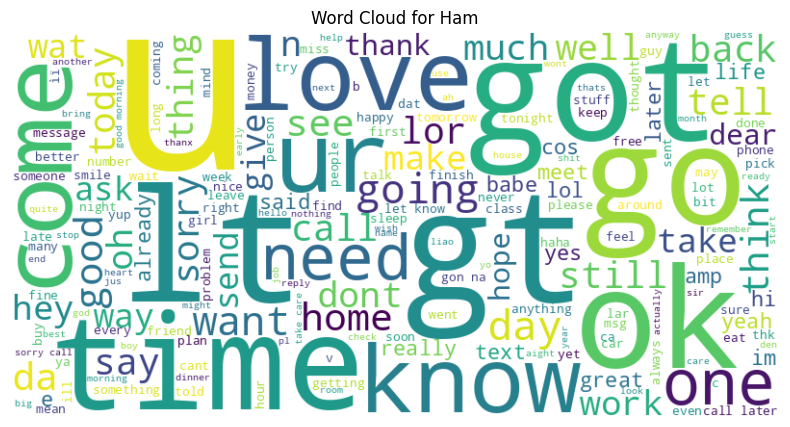


Top 10 words for Spam:
call: 346
free: 219
2: 174
txt: 156
ur: 144
u: 141
mobile: 123
text: 121
4: 120
stop: 114

Top 10 bigrams for Spam:
please call: 45
po box: 24
guaranteed call: 23
prize guaranteed: 22
send stop: 19
every week: 19
await collection: 19
urgent mobile: 18
land line: 18
customer service: 17

Top 10 trigrams for Spam:
prize guaranteed call: 21
reply call 08000930705: 14
land line claim: 14
draw shows prize: 13
shows prize guaranteed: 13
private 2003 account: 13
2003 account statement: 13
camcorder reply call: 12
shows 800 points: 12
800 points call: 12


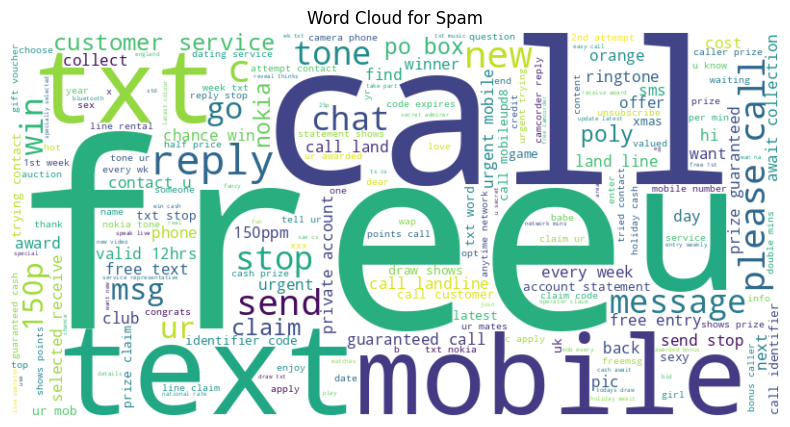

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



F1-score for Bag-of-Words (Logistic Regression): 0.9007
BoW Cross-validation F1-scores: 0.9196 ± 0.0236


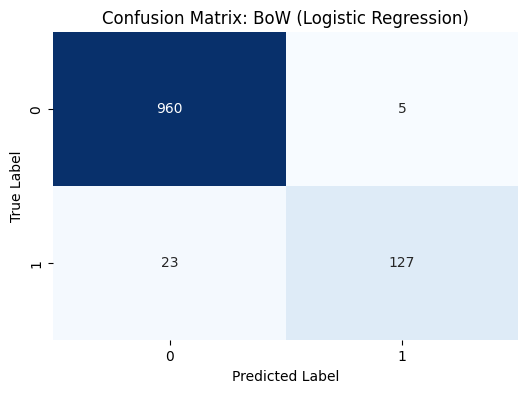

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression): 0.9039


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

TF-IDF Cross-validation F1-scores: 0.8986 ± 0.0254


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


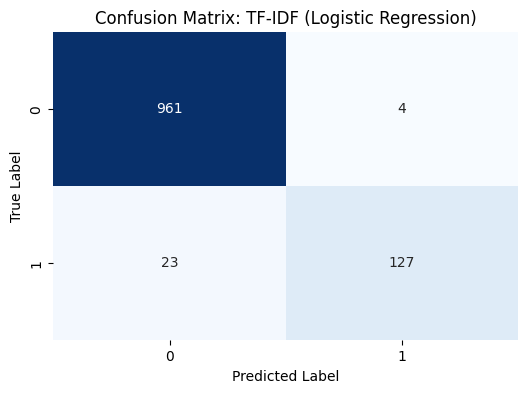

F1-score for Naive Bayes (BoW): 0.9301
Naive Bayes Cross-validation F1-scores: 0.9081 ± 0.0191


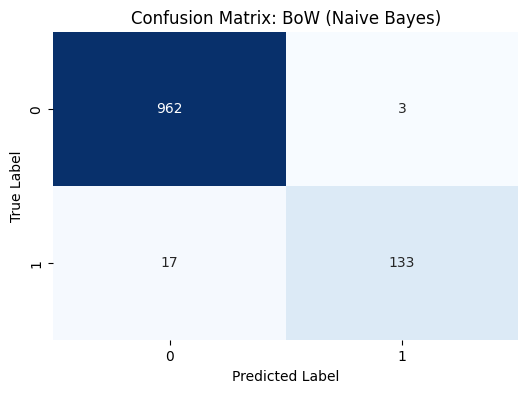

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

F1-score for SVM (TF-IDF): 0.9268


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Cross-validation F1-scores: 0.9151 ± 0.0298


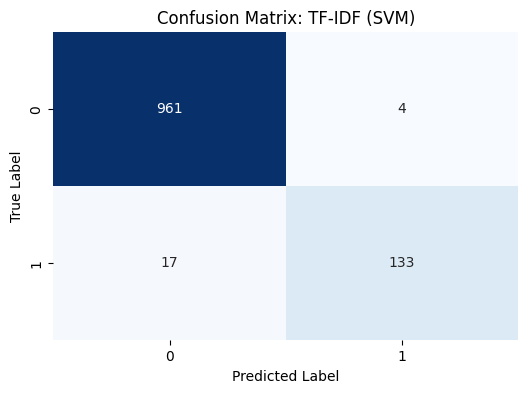

F1-score for Random Forest (TF-IDF): 0.8764
Random Forest Cross-validation F1-scores: 0.8797 ± 0.0158


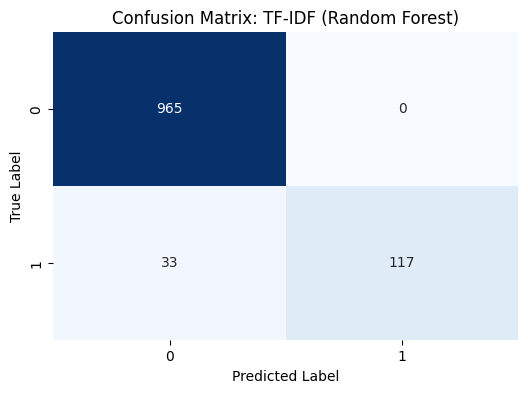


Summary of F1-scores:
BoW (Logistic Regression): 0.9007
TF-IDF (Logistic Regression): 0.9039
BoW (Naive Bayes): 0.9301
TF-IDF (SVM): 0.9268
TF-IDF (Random Forest): 0.8764


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


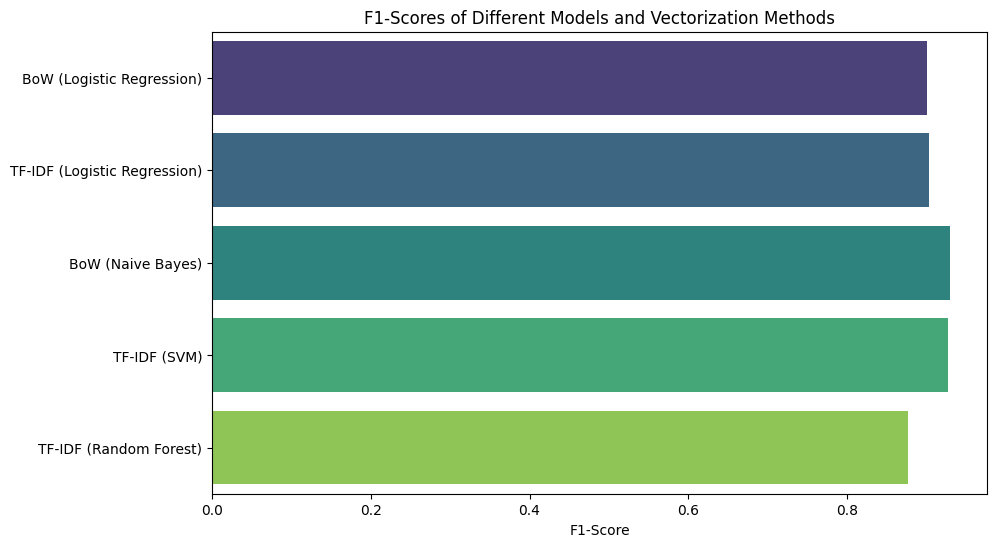

In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import seaborn as sns
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only label and text columns
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text for EDA
def preprocess_for_eda(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]  # Keep alphanumeric
    return tokens

# Function to get n-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# EDA: Most frequent words, bigrams, trigrams
def perform_eda(df, class_label, class_name):
    class_texts = df[df['label'] == class_label]['text']
    all_tokens = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        all_tokens.extend(tokens)
    
    # Most frequent words
    word_counts = Counter(all_tokens)
    print(f"\nTop 10 words for {class_name}:")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    # Most frequent bigrams
    bigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        bigrams.extend(get_ngrams(tokens, 2))
    bigram_counts = Counter(bigrams)
    print(f"\nTop 10 bigrams for {class_name}:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"{' '.join(bigram)}: {count}")
    
    # Most frequent trigrams
    trigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        trigrams.extend(get_ngrams(tokens, 3))
    trigram_counts = Counter(trigrams)
    print(f"\nTop 10 trigrams for {class_name}:")
    for trigram, count in trigram_counts.most_common(10):
        print(f"{' '.join(trigram)}: {count}")
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()

# Perform EDA for ham and spam
perform_eda(df, 0, 'Ham')
perform_eda(df, 1, 'Spam')

# Feature engineering: Extract message length and keyword presence
def extract_features(df):
    df['length'] = df['text'].apply(len)
    spam_keywords = ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']
    for keyword in spam_keywords:
        df[f'has_{keyword}'] = df['text'].str.lower().str.contains(keyword).astype(int)
    return df

df = extract_features(df)

# Split dataset
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modified preprocessing function (keep numbers and punctuation)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and (t.isalnum() or t in ['!', '?'])]  # Keep alphanumeric and !, ?
    return ' '.join(tokens)

# Prepare features
X_train_text = X_train['text'].apply(preprocess_text)
X_test_text = X_test['text'].apply(preprocess_text)

# Additional features (length and keywords)
additional_features = ['length'] + [f'has_{kw}' for kw in ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']]
X_train_additional = X_train[additional_features].values
X_test_additional = X_test[additional_features].values

# Scale additional features
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 1. Bag-of-Words with n-grams
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

# Combine BoW with additional features
X_train_bow_combined = hstack([X_train_bow, X_train_additional])
X_test_bow_combined = hstack([X_test_bow, X_test_additional])

# Logistic Regression with GridSearchCV
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
grid_lr_bow = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_bow.fit(X_train_bow_combined, y_train)
y_pred_bow = grid_lr_bow.predict(X_test_bow_combined)
f1_bow = f1_score(y_test, y_pred_bow)
print(f"\nF1-score for Bag-of-Words (Logistic Regression): {f1_bow:.4f}")
bow_cv_scores = cross_val_score(grid_lr_bow.best_estimator_, X_train_bow_combined, y_train, cv=5, scoring='f1')
print(f"BoW Cross-validation F1-scores: {bow_cv_scores.mean():.4f} ± {bow_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_bow, 'BoW (Logistic Regression)')

# 2. TF-IDF with n-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Combine TF-IDF with additional features
X_train_tfidf_combined = hstack([X_train_tfidf, X_train_additional])
X_test_tfidf_combined = hstack([X_test_tfidf, X_test_additional])

# Logistic Regression with GridSearchCV
grid_lr_tfidf = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf.fit(X_train_tfidf_combined, y_train)
y_pred_tfidf = grid_lr_tfidf.predict(X_test_tfidf_combined)
f1_tfidf = f1_score(y_test, y_pred_tfidf)
print(f"F1-score for TF-IDF (Logistic Regression): {f1_tfidf:.4f}")
tfidf_cv_scores = cross_val_score(grid_lr_tfidf.best_estimator_, X_train_tfidf_combined, y_train, cv=5, scoring='f1')
print(f"TF-IDF Cross-validation F1-scores: {tfidf_cv_scores.mean():.4f} ± {tfidf_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf, 'TF-IDF (Logistic Regression)')

# 3. Naive Bayes with BoW
nb = MultinomialNB()
X_train_additional_nb = scaler.fit_transform(X_train[additional_features].values)
X_train_additional_nb = (X_train_additional_nb - X_train_additional_nb.min()) / (X_train_additional_nb.max() - X_train_additional_nb.min())
X_test_additional_nb = scaler.transform(X_test[additional_features].values)
X_test_additional_nb = (X_test_additional_nb - X_test_additional_nb.min()) / (X_test_additional_nb.max() - X_test_additional_nb.min())
X_train_bow_nb = hstack([X_train_bow, X_train_additional_nb])
X_test_bow_nb = hstack([X_test_bow, X_test_additional_nb])
nb.fit(X_train_bow_nb, y_train)
y_pred_nb = nb.predict(X_test_bow_nb)
f1_nb = f1_score(y_test, y_pred_nb)
print(f"F1-score for Naive Bayes (BoW): {f1_nb:.4f}")
nb_cv_scores = cross_val_score(nb, X_train_bow_nb, y_train, cv=5, scoring='f1')
print(f"Naive Bayes Cross-validation F1-scores: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_nb, 'BoW (Naive Bayes)')

# 4. SVM with TF-IDF
svm = LinearSVC(random_state=42)
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100]}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_tfidf_combined, y_train)
y_pred_svm = grid_svm.predict(X_test_tfidf_combined)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"F1-score for SVM (TF-IDF): {f1_svm:.4f}")
svm_cv_scores = cross_val_score(grid_svm.best_estimator_, X_train_tfidf_combined, y_train, cv=5, scoring='f1')
print(f"SVM Cross-validation F1-scores: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_svm, 'TF-IDF (SVM)')

# 5. Random Forest with TF-IDF
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_tfidf_combined, y_train)
y_pred_rf = grid_rf.predict(X_test_tfidf_combined)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1-score for Random Forest (TF-IDF): {f1_rf:.4f}")
rf_cv_scores = cross_val_score(grid_rf.best_estimator_, X_train_tfidf_combined, y_train, cv=5, scoring='f1')
print(f"Random Forest Cross-validation F1-scores: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_rf, 'TF-IDF (Random Forest)')

# Summary of F1-scores
f1_scores = {
    'BoW (Logistic Regression)': f1_bow,
    'TF-IDF (Logistic Regression)': f1_tfidf,
    'BoW (Naive Bayes)': f1_nb,
    'TF-IDF (SVM)': f1_svm,
    'TF-IDF (Random Forest)': f1_rf
}
print("\nSummary of F1-scores:")
for method, score in f1_scores.items():
    print(f"{method}: {score:.4f}")

# Visualize F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis')
plt.xlabel('F1-Score')
plt.title('F1-Scores of Different Models and Vectorization Methods')
plt.show()

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Top 10 words for Ham:
u: 979
gt: 318
lt: 316
get: 301
2: 300
go: 248
ok: 245
got: 242
ur: 237
know: 236

Top 10 bigrams for Ham:
lt gt: 276
gon na: 58
call later: 50
let know: 39
sorry call: 38
r u: 37
u r: 35
good morning: 31
take care: 31
wan 2: 31

Top 10 trigrams for Ham:
sorry call later: 38
lt decimal gt: 23
u wan 2: 21
happy new year: 18
gt lt gt: 17
lt gt lt: 15
like lt gt: 14
pls send message: 13
cant pick phone: 12
pick phone right: 12


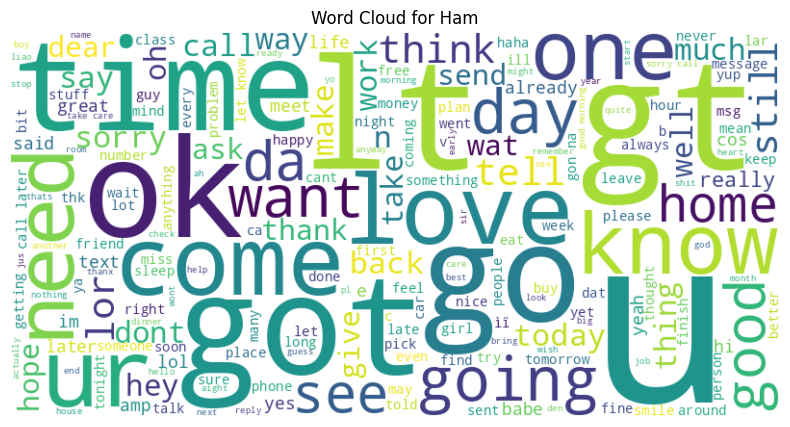


Top 10 words for Spam:
call: 346
free: 219
2: 174
txt: 156
ur: 144
u: 141
mobile: 123
text: 121
4: 120
stop: 114

Top 10 bigrams for Spam:
please call: 45
po box: 24
guaranteed call: 23
prize guaranteed: 22
send stop: 19
every week: 19
await collection: 19
urgent mobile: 18
land line: 18
customer service: 17

Top 10 trigrams for Spam:
prize guaranteed call: 21
reply call 08000930705: 14
land line claim: 14
draw shows prize: 13
shows prize guaranteed: 13
private 2003 account: 13
2003 account statement: 13
camcorder reply call: 12
shows 800 points: 12
800 points call: 12


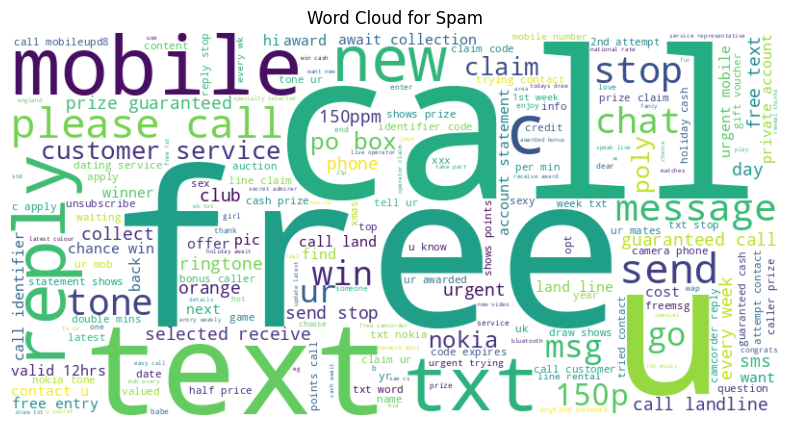

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



F1-score for BoW (Logistic Regression, Pre-v1): 0.9007
Cross-validation F1-scores: 0.9196 ± 0.0236


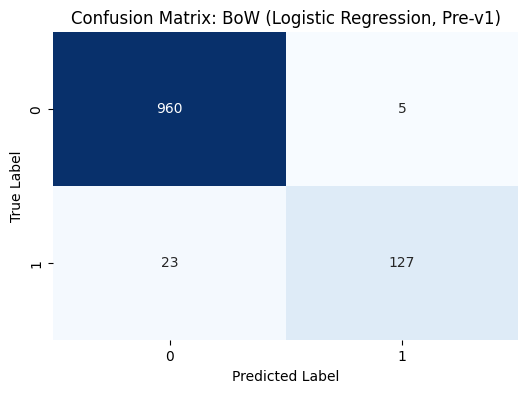

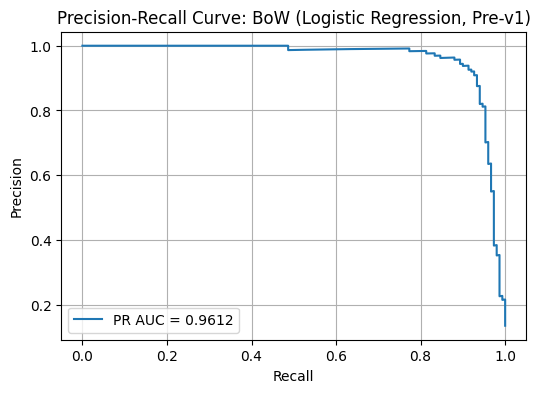

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v1): 0.9039
Cross-validation F1-scores: 0.8986 ± 0.0254


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


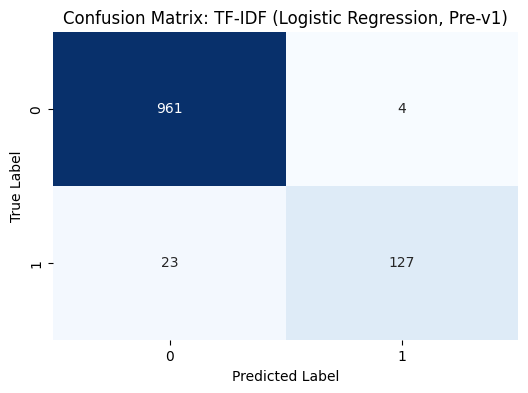

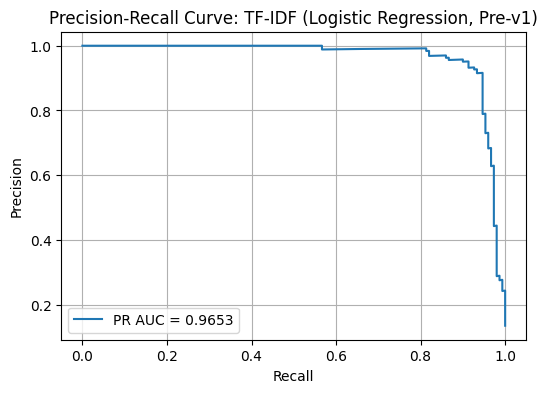

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v2): 0.9123
Cross-validation F1-scores: 0.9010 ± 0.0258


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


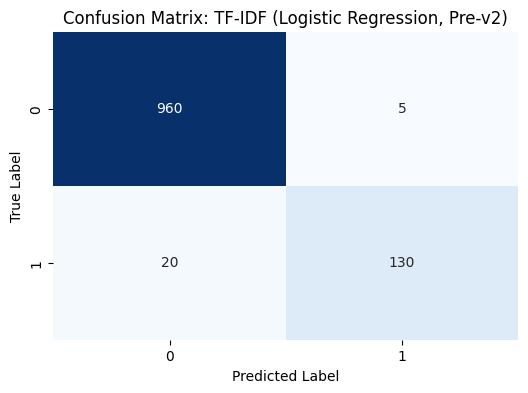

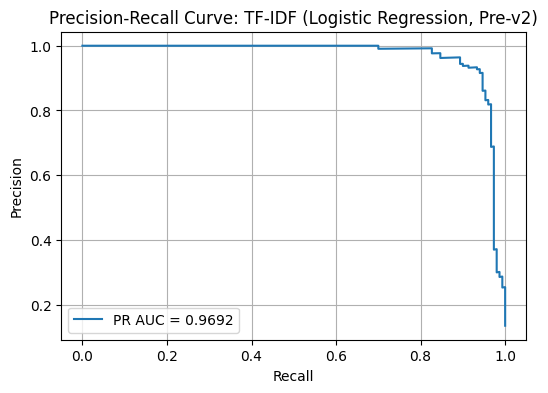

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v3): 0.9039
Cross-validation F1-scores: 0.9025 ± 0.0215


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


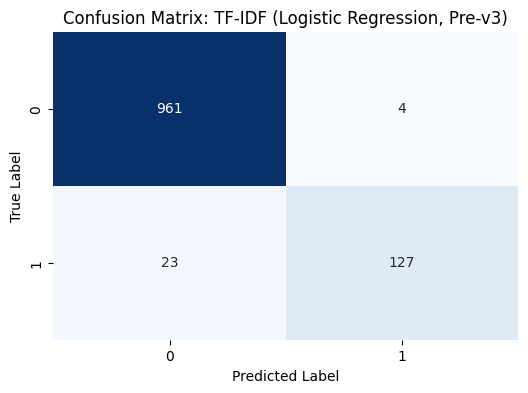

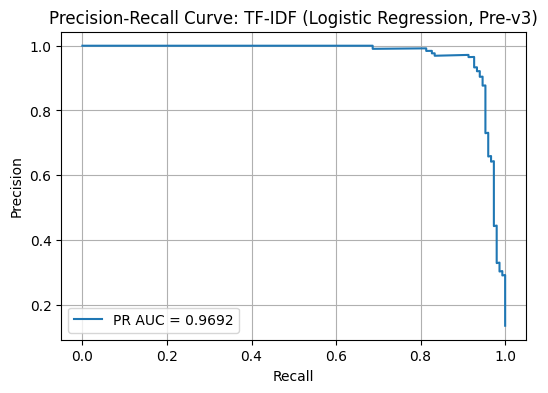

F1-score for BoW (Naive Bayes, Pre-v1): 0.9301
Cross-validation F1-scores: 0.9081 ± 0.0191


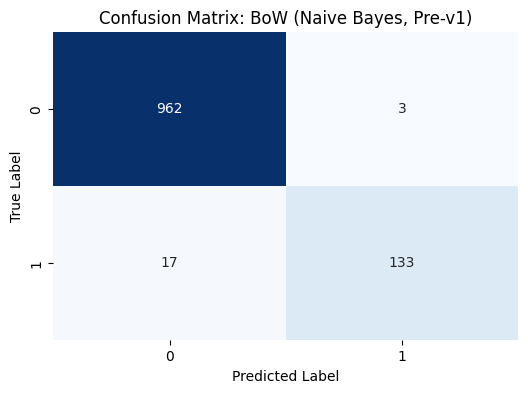

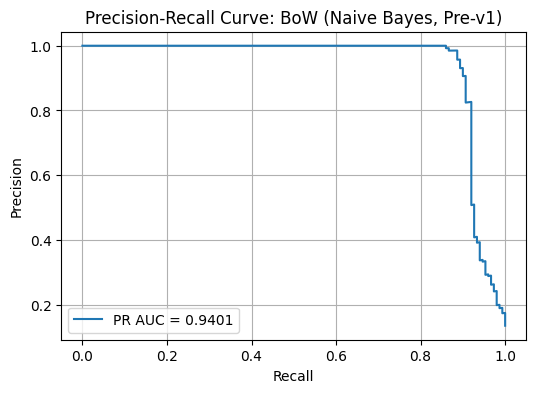

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

F1-score for TF-IDF (SVM, Pre-v1): 0.9268
Cross-validation F1-scores: 0.9151 ± 0.0298


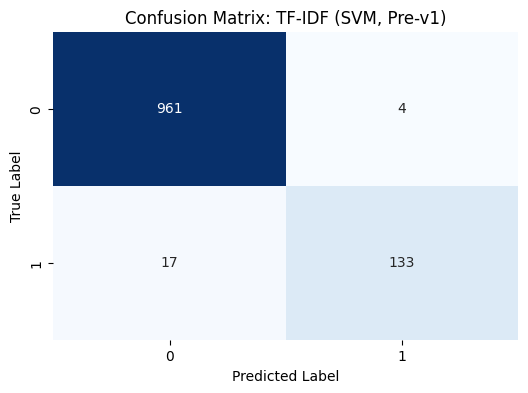

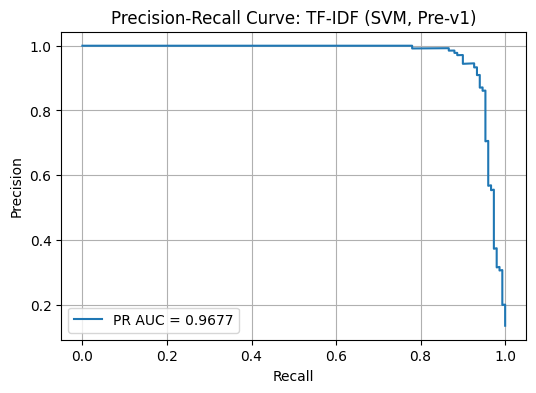

F1-score for TF-IDF (Random Forest, Pre-v1): 0.8764
Cross-validation F1-scores: 0.8797 ± 0.0158


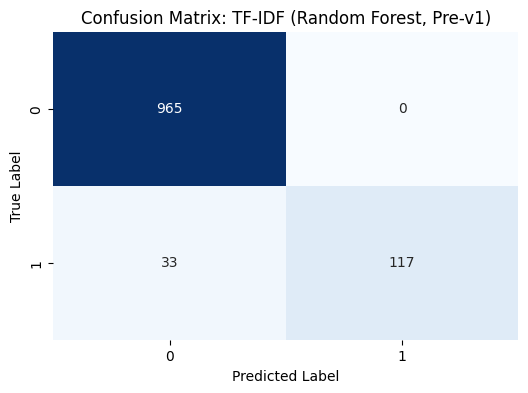

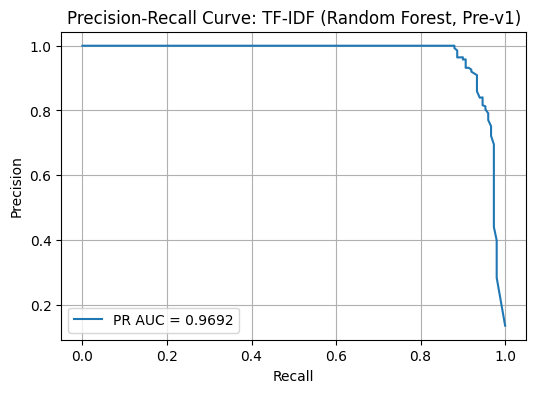

F1-score for TF-IDF (XGBoost, Pre-v1): 0.8849
Cross-validation F1-scores: 0.8941 ± 0.0163


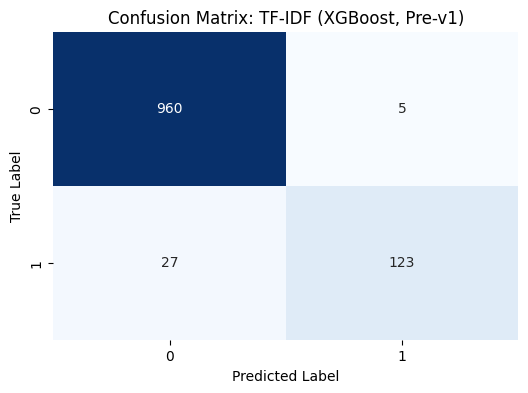

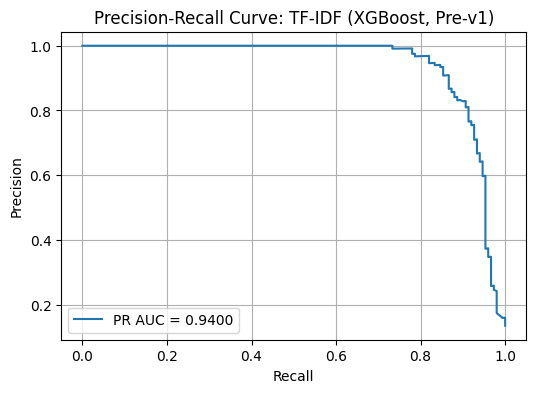


Summary of F1-scores:
BoW (Logistic Regression, Pre-v1): 0.9007
TF-IDF (Logistic Regression, Pre-v1): 0.9039
TF-IDF (Logistic Regression, Pre-v2): 0.9123
TF-IDF (Logistic Regression, Pre-v3): 0.9039
BoW (Naive Bayes, Pre-v1): 0.9301
TF-IDF (SVM, Pre-v1): 0.9268
TF-IDF (Random Forest, Pre-v1): 0.8764
TF-IDF (XGBoost, Pre-v1): 0.8849

Summary of Cross-validation F1-scores (Mean ± Std):
BoW (Logistic Regression, Pre-v1): 0.9196 ± 0.0236
TF-IDF (Logistic Regression, Pre-v1): 0.8986 ± 0.0254
TF-IDF (Logistic Regression, Pre-v2): 0.9010 ± 0.0258
TF-IDF (Logistic Regression, Pre-v3): 0.9025 ± 0.0215
BoW (Naive Bayes, Pre-v1): 0.9081 ± 0.0191
TF-IDF (SVM, Pre-v1): 0.9151 ± 0.0298
TF-IDF (Random Forest, Pre-v1): 0.8797 ± 0.0158
TF-IDF (XGBoost, Pre-v1): 0.8941 ± 0.0163


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


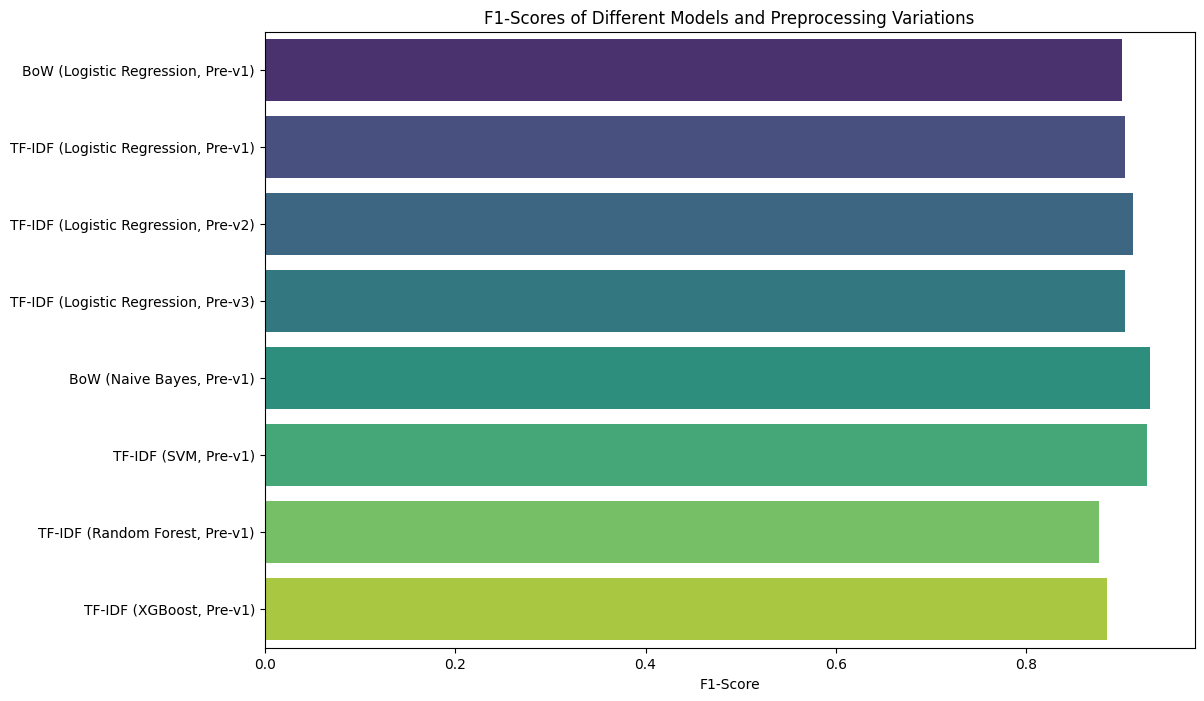

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import seaborn as sns
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only label and text columns
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize stop words, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function to preprocess text for EDA
def preprocess_for_eda(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]  # Keep alphanumeric
    return tokens

# Function to get n-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# EDA: Most frequent words, bigrams, trigrams
def perform_eda(df, class_label, class_name):
    class_texts = df[df['label'] == class_label]['text']
    all_tokens = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        all_tokens.extend(tokens)
    
    # Most frequent words
    word_counts = Counter(all_tokens)
    print(f"\nTop 10 words for {class_name}:")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    # Most frequent bigrams
    bigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        bigrams.extend(get_ngrams(tokens, 2))
    bigram_counts = Counter(bigrams)
    print(f"\nTop 10 bigrams for {class_name}:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"{' '.join(bigram)}: {count}")
    
    # Most frequent trigrams
    trigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        trigrams.extend(get_ngrams(tokens, 3))
    trigram_counts = Counter(trigrams)
    print(f"\nTop 10 trigrams for {class_name}:")
    for trigram, count in trigram_counts.most_common(10):
        print(f"{' '.join(trigram)}: {count}")
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()

# Perform EDA for ham and spam
perform_eda(df, 0, 'Ham')
perform_eda(df, 1, 'Spam')

# Feature engineering: Extract message length and keyword presence
def extract_features(df):
    df['length'] = df['text'].apply(len)
    spam_keywords = ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']
    for keyword in spam_keywords:
        df[f'has_{keyword}'] = df['text'].str.lower().str.contains(keyword).astype(int)
    return df

df = extract_features(df)

# Split dataset
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing variations
def preprocess_text_v1(text):  # Keep ! and ?, lemmatization
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and (t.isalnum() or t in ['!', '?'])]
    return ' '.join(tokens)

def preprocess_text_v2(text):  # Keep all punctuation, lemmatization
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

def preprocess_text_v3(text):  # Keep ! and ?, stemming
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and (t.isalnum() or t in ['!', '?'])]
    return ' '.join(tokens)

# Prepare features for all preprocessing variations
X_train_text_v1 = X_train['text'].apply(preprocess_text_v1)
X_test_text_v1 = X_test['text'].apply(preprocess_text_v1)
X_train_text_v2 = X_train['text'].apply(preprocess_text_v2)
X_test_text_v2 = X_test['text'].apply(preprocess_text_v2)
X_train_text_v3 = X_train['text'].apply(preprocess_text_v3)
X_test_text_v3 = X_test['text'].apply(preprocess_text_v3)

# Additional features (length and keywords)
additional_features = ['length'] + [f'has_{kw}' for kw in ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']]
X_train_additional = X_train[additional_features].values
X_test_additional = X_test[additional_features].values

# Scale additional features
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores, title):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialize results dictionary
f1_scores = {}
cv_scores = {}

# 1. Bag-of-Words with Logistic Regression (Preprocessing v1)
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train_text_v1)
X_test_bow = bow_vectorizer.transform(X_test_text_v1)
X_train_bow_combined = hstack([X_train_bow, X_train_additional])
X_test_bow_combined = hstack([X_test_bow, X_test_additional])

param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
grid_lr_bow = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_bow.fit(X_train_bow_combined, y_train)
y_pred_bow = grid_lr_bow.predict(X_test_bow_combined)
y_scores_bow = grid_lr_bow.predict_proba(X_test_bow_combined)[:, 1]
f1_bow = f1_score(y_test, y_pred_bow)
f1_scores['BoW (Logistic Regression, Pre-v1)'] = f1_bow
bow_cv_scores = cross_val_score(grid_lr_bow.best_estimator_, X_train_bow_combined, y_train, cv=5, scoring='f1')
cv_scores['BoW (Logistic Regression, Pre-v1)'] = (bow_cv_scores.mean(), bow_cv_scores.std())
print(f"\nF1-score for BoW (Logistic Regression, Pre-v1): {f1_bow:.4f}")
print(f"Cross-validation F1-scores: {bow_cv_scores.mean():.4f} ± {bow_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_bow, 'BoW (Logistic Regression, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_bow, 'BoW (Logistic Regression, Pre-v1)')

# 2. TF-IDF with Logistic Regression (Preprocessing v1)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_v1 = tfidf_vectorizer.fit_transform(X_train_text_v1)
X_test_tfidf_v1 = tfidf_vectorizer.transform(X_test_text_v1)
X_train_tfidf_v1_combined = hstack([X_train_tfidf_v1, X_train_additional])
X_test_tfidf_v1_combined = hstack([X_test_tfidf_v1, X_test_additional])

grid_lr_tfidf_v1 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v1.fit(X_train_tfidf_v1_combined, y_train)
y_pred_tfidf_v1 = grid_lr_tfidf_v1.predict(X_test_tfidf_v1_combined)
y_scores_tfidf_v1 = grid_lr_tfidf_v1.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_tfidf_v1 = f1_score(y_test, y_pred_tfidf_v1)
f1_scores['TF-IDF (Logistic Regression, Pre-v1)'] = f1_tfidf_v1
tfidf_v1_cv_scores = cross_val_score(grid_lr_tfidf_v1.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v1)'] = (tfidf_v1_cv_scores.mean(), tfidf_v1_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v1): {f1_tfidf_v1:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v1_cv_scores.mean():.4f} ± {tfidf_v1_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v1, 'TF-IDF (Logistic Regression, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v1, 'TF-IDF (Logistic Regression, Pre-v1)')

# 3. TF-IDF with Logistic Regression (Preprocessing v2: Keep all punctuation)
X_train_tfidf_v2 = tfidf_vectorizer.fit_transform(X_train_text_v2)
X_test_tfidf_v2 = tfidf_vectorizer.transform(X_test_text_v2)
X_train_tfidf_v2_combined = hstack([X_train_tfidf_v2, X_train_additional])
X_test_tfidf_v2_combined = hstack([X_test_tfidf_v2, X_test_additional])

grid_lr_tfidf_v2 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v2.fit(X_train_tfidf_v2_combined, y_train)
y_pred_tfidf_v2 = grid_lr_tfidf_v2.predict(X_test_tfidf_v2_combined)
y_scores_tfidf_v2 = grid_lr_tfidf_v2.predict_proba(X_test_tfidf_v2_combined)[:, 1]
f1_tfidf_v2 = f1_score(y_test, y_pred_tfidf_v2)
f1_scores['TF-IDF (Logistic Regression, Pre-v2)'] = f1_tfidf_v2
tfidf_v2_cv_scores = cross_val_score(grid_lr_tfidf_v2.best_estimator_, X_train_tfidf_v2_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v2)'] = (tfidf_v2_cv_scores.mean(), tfidf_v2_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v2): {f1_tfidf_v2:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v2_cv_scores.mean():.4f} ± {tfidf_v2_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v2, 'TF-IDF (Logistic Regression, Pre-v2)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v2, 'TF-IDF (Logistic Regression, Pre-v2)')

# 4. TF-IDF with Logistic Regression (Preprocessing v3: Stemming)
X_train_tfidf_v3 = tfidf_vectorizer.fit_transform(X_train_text_v3)
X_test_tfidf_v3 = tfidf_vectorizer.transform(X_test_text_v3)
X_train_tfidf_v3_combined = hstack([X_train_tfidf_v3, X_train_additional])
X_test_tfidf_v3_combined = hstack([X_test_tfidf_v3, X_test_additional])

grid_lr_tfidf_v3 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v3.fit(X_train_tfidf_v3_combined, y_train)
y_pred_tfidf_v3 = grid_lr_tfidf_v3.predict(X_test_tfidf_v3_combined)
y_scores_tfidf_v3 = grid_lr_tfidf_v3.predict_proba(X_test_tfidf_v3_combined)[:, 1]
f1_tfidf_v3 = f1_score(y_test, y_pred_tfidf_v3)
f1_scores['TF-IDF (Logistic Regression, Pre-v3)'] = f1_tfidf_v3
tfidf_v3_cv_scores = cross_val_score(grid_lr_tfidf_v3.best_estimator_, X_train_tfidf_v3_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v3)'] = (tfidf_v3_cv_scores.mean(), tfidf_v3_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v3): {f1_tfidf_v3:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v3_cv_scores.mean():.4f} ± {tfidf_v3_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v3, 'TF-IDF (Logistic Regression, Pre-v3)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v3, 'TF-IDF (Logistic Regression, Pre-v3)')

# 5. Naive Bayes with BoW (Preprocessing v1)
nb = MultinomialNB()
X_train_additional_nb = scaler.fit_transform(X_train[additional_features].values)
X_train_additional_nb = (X_train_additional_nb - X_train_additional_nb.min()) / (X_train_additional_nb.max() - X_train_additional_nb.min())
X_test_additional_nb = scaler.transform(X_test[additional_features].values)
X_test_additional_nb = (X_test_additional_nb - X_test_additional_nb.min()) / (X_test_additional_nb.max() - X_test_additional_nb.min())
X_train_bow_nb = hstack([X_train_bow, X_train_additional_nb])
X_test_bow_nb = hstack([X_test_bow, X_test_additional_nb])
nb.fit(X_train_bow_nb, y_train)
y_pred_nb = nb.predict(X_test_bow_nb)
y_scores_nb = nb.predict_proba(X_test_bow_nb)[:, 1]
f1_nb = f1_score(y_test, y_pred_nb)
f1_scores['BoW (Naive Bayes, Pre-v1)'] = f1_nb
nb_cv_scores = cross_val_score(nb, X_train_bow_nb, y_train, cv=5, scoring='f1')
cv_scores['BoW (Naive Bayes, Pre-v1)'] = (nb_cv_scores.mean(), nb_cv_scores.std())
print(f"F1-score for BoW (Naive Bayes, Pre-v1): {f1_nb:.4f}")
print(f"Cross-validation F1-scores: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_nb, 'BoW (Naive Bayes, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_nb, 'BoW (Naive Bayes, Pre-v1)')

# 6. SVM with TF-IDF (Preprocessing v1)
svm = LinearSVC(random_state=42)
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100]}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_tfidf_v1_combined, y_train)
y_pred_svm = grid_svm.predict(X_test_tfidf_v1_combined)
y_scores_svm = grid_svm.decision_function(X_test_tfidf_v1_combined)
f1_svm = f1_score(y_test, y_pred_svm)
f1_scores['TF-IDF (SVM, Pre-v1)'] = f1_svm
svm_cv_scores = cross_val_score(grid_svm.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (SVM, Pre-v1)'] = (svm_cv_scores.mean(), svm_cv_scores.std())
print(f"F1-score for TF-IDF (SVM, Pre-v1): {f1_svm:.4f}")
print(f"Cross-validation F1-scores: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_svm, 'TF-IDF (SVM, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_svm, 'TF-IDF (SVM, Pre-v1)')

# 7. Random Forest with TF-IDF (Preprocessing v1)
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_tfidf_v1_combined, y_train)
y_pred_rf = grid_rf.predict(X_test_tfidf_v1_combined)
y_scores_rf = grid_rf.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_rf = f1_score(y_test, y_pred_rf)
f1_scores['TF-IDF (Random Forest, Pre-v1)'] = f1_rf
rf_cv_scores = cross_val_score(grid_rf.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Random Forest, Pre-v1)'] = (rf_cv_scores.mean(), rf_cv_scores.std())
print(f"F1-score for TF-IDF (Random Forest, Pre-v1): {f1_rf:.4f}")
print(f"Cross-validation F1-scores: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_rf, 'TF-IDF (Random Forest, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_rf, 'TF-IDF (Random Forest, Pre-v1)')

# 8. XGBoost with TF-IDF (Preprocessing v1)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 10]}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_tfidf_v1_combined, y_train)
y_pred_xgb = grid_xgb.predict(X_test_tfidf_v1_combined)
y_scores_xgb = grid_xgb.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_scores['TF-IDF (XGBoost, Pre-v1)'] = f1_xgb
xgb_cv_scores = cross_val_score(grid_xgb.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (XGBoost, Pre-v1)'] = (xgb_cv_scores.mean(), xgb_cv_scores.std())
print(f"F1-score for TF-IDF (XGBoost, Pre-v1): {f1_xgb:.4f}")
print(f"Cross-validation F1-scores: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_xgb, 'TF-IDF (XGBoost, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_xgb, 'TF-IDF (XGBoost, Pre-v1)')

# Summary of F1-scores
print("\nSummary of F1-scores:")
for method, score in f1_scores.items():
    print(f"{method}: {score:.4f}")
print("\nSummary of Cross-validation F1-scores (Mean ± Std):")
for method, (mean, std) in cv_scores.items():
    print(f"{method}: {mean:.4f} ± {std:.4f}")

# Visualize F1-scores
plt.figure(figsize=(12, 8))
sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis')
plt.xlabel('F1-Score')
plt.title('F1-Scores of Different Models and Preprocessing Variations')
plt.show()

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Top 10 words for Ham:
u: 979
gt: 318
lt: 316
get: 301
2: 300
go: 248
ok: 245
got: 242
ur: 237
know: 236

Top 10 bigrams for Ham:
lt gt: 276
gon na: 58
call later: 50
let know: 39
sorry call: 38
r u: 37
u r: 35
good morning: 31
take care: 31
wan 2: 31

Top 10 trigrams for Ham:
sorry call later: 38
lt decimal gt: 23
u wan 2: 21
happy new year: 18
gt lt gt: 17
lt gt lt: 15
like lt gt: 14
pls send message: 13
cant pick phone: 12
pick phone right: 12


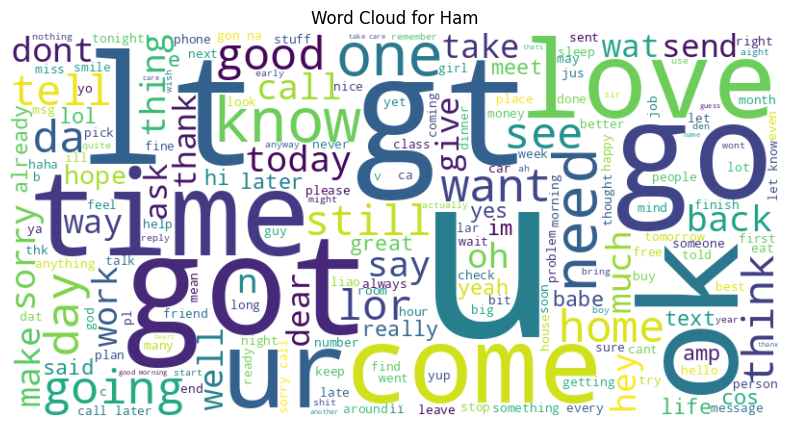


Top 10 words for Spam:
call: 346
free: 219
2: 174
txt: 156
ur: 144
u: 141
mobile: 123
text: 121
4: 120
stop: 114

Top 10 bigrams for Spam:
please call: 45
po box: 24
guaranteed call: 23
prize guaranteed: 22
send stop: 19
every week: 19
await collection: 19
urgent mobile: 18
land line: 18
customer service: 17

Top 10 trigrams for Spam:
prize guaranteed call: 21
reply call 08000930705: 14
land line claim: 14
draw shows prize: 13
shows prize guaranteed: 13
private 2003 account: 13
2003 account statement: 13
camcorder reply call: 12
shows 800 points: 12
800 points call: 12


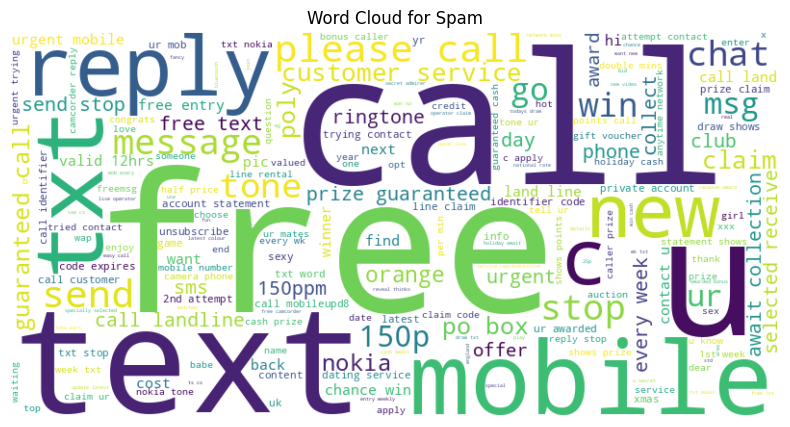

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



F1-score for BoW (Logistic Regression, Pre-v1): 0.9007
Cross-validation F1-scores: 0.9196 ± 0.0236


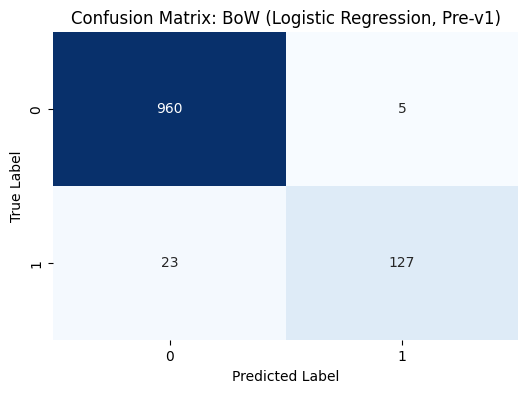

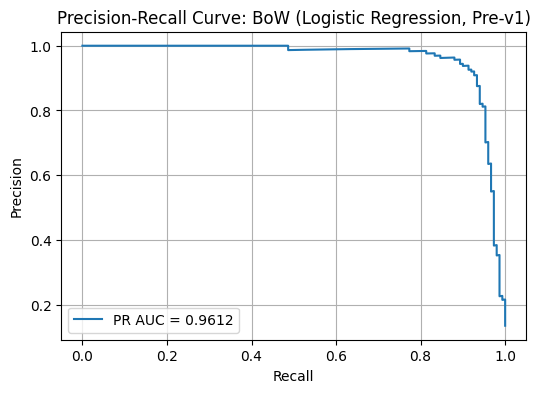

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v1): 0.9039
Cross-validation F1-scores: 0.8986 ± 0.0254


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


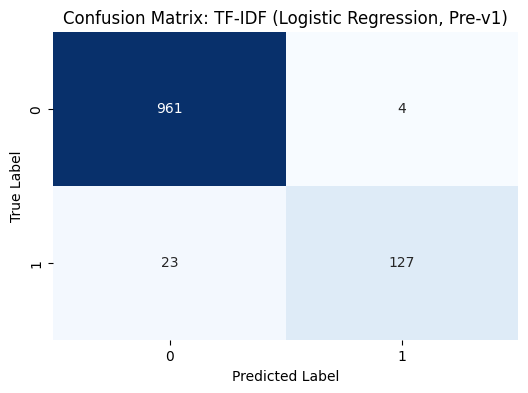

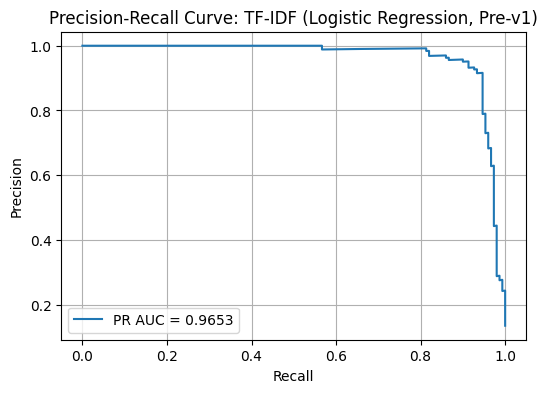

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v2): 0.9123
Cross-validation F1-scores: 0.9010 ± 0.0258


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


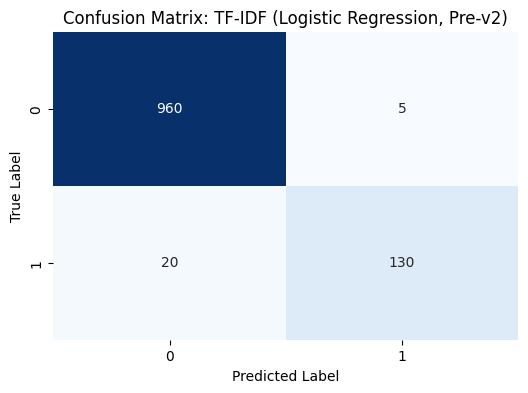

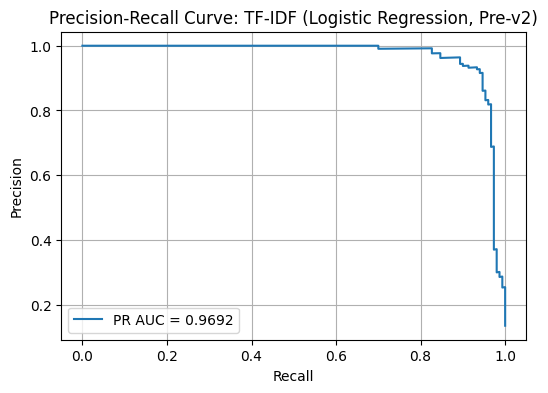

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-score for TF-IDF (Logistic Regression, Pre-v3): 0.9039
Cross-validation F1-scores: 0.9025 ± 0.0215


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


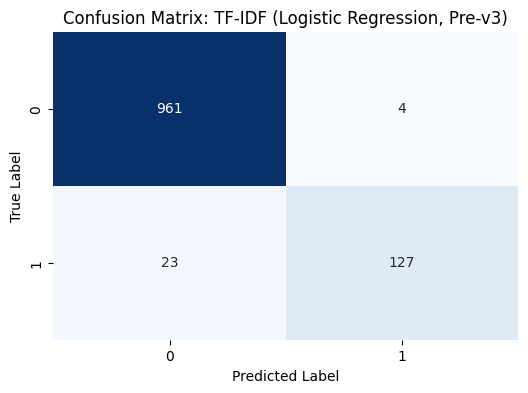

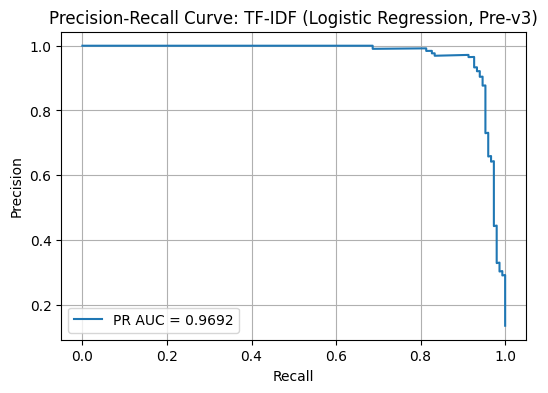

F1-score for BoW (Naive Bayes, Pre-v1): 0.9301
Cross-validation F1-scores: 0.9081 ± 0.0191


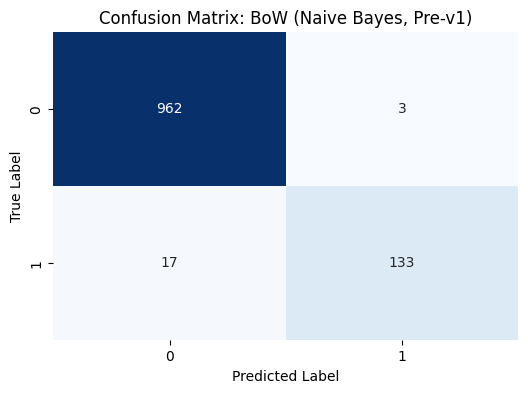

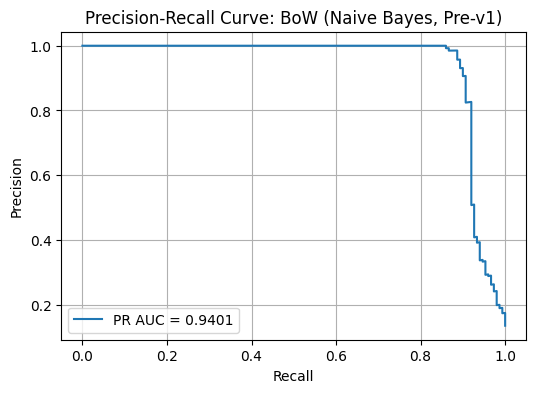

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

F1-score for TF-IDF (SVM, Pre-v1): 0.9268
Cross-validation F1-scores: 0.9151 ± 0.0298


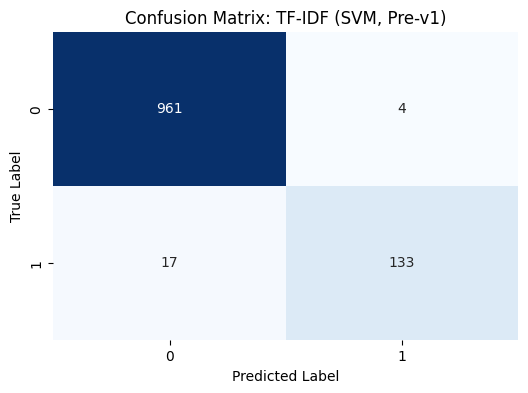

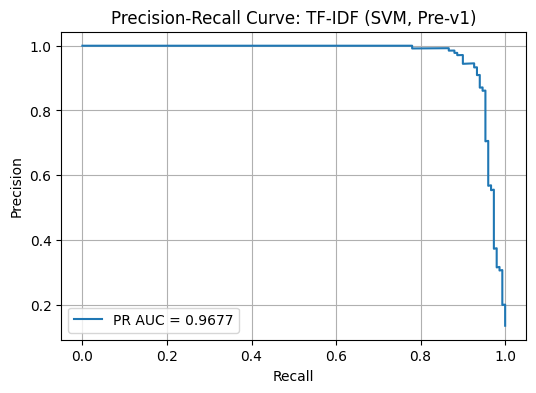

F1-score for TF-IDF (Random Forest, Pre-v1): 0.8764
Cross-validation F1-scores: 0.8797 ± 0.0158


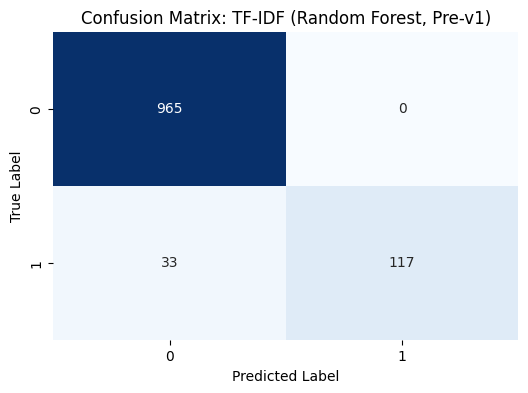

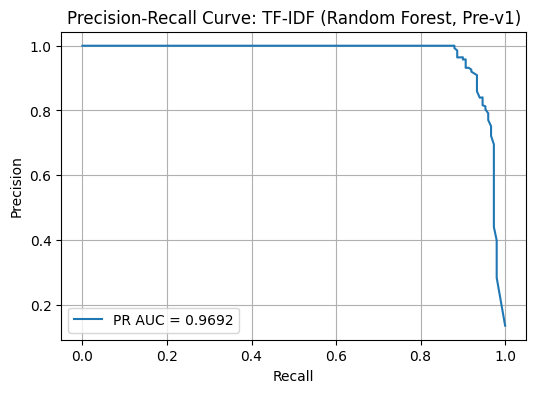

F1-score for TF-IDF (XGBoost, Pre-v1): 0.8849
Cross-validation F1-scores: 0.8941 ± 0.0163


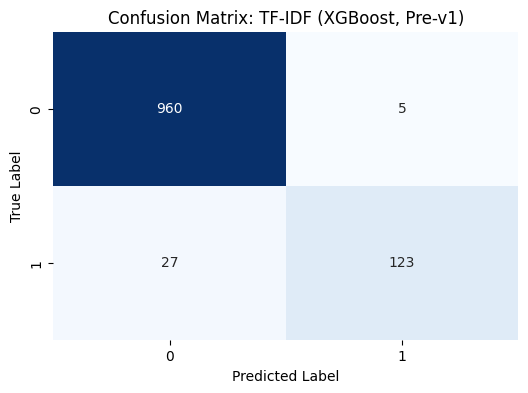

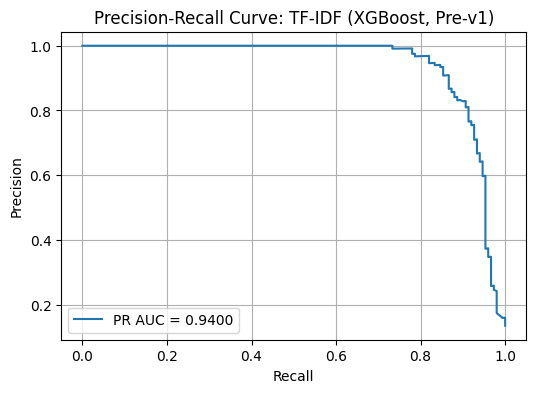


Summary of F1-scores:
BoW (Logistic Regression, Pre-v1): 0.9007
TF-IDF (Logistic Regression, Pre-v1): 0.9039
TF-IDF (Logistic Regression, Pre-v2): 0.9123
TF-IDF (Logistic Regression, Pre-v3): 0.9039
BoW (Naive Bayes, Pre-v1): 0.9301
TF-IDF (SVM, Pre-v1): 0.9268
TF-IDF (Random Forest, Pre-v1): 0.8764
TF-IDF (XGBoost, Pre-v1): 0.8849

Summary of Cross-validation F1-scores (Mean ± Std):
BoW (Logistic Regression, Pre-v1): 0.9196 ± 0.0236
TF-IDF (Logistic Regression, Pre-v1): 0.8986 ± 0.0254
TF-IDF (Logistic Regression, Pre-v2): 0.9010 ± 0.0258
TF-IDF (Logistic Regression, Pre-v3): 0.9025 ± 0.0215
BoW (Naive Bayes, Pre-v1): 0.9081 ± 0.0191
TF-IDF (SVM, Pre-v1): 0.9151 ± 0.0298
TF-IDF (Random Forest, Pre-v1): 0.8797 ± 0.0158
TF-IDF (XGBoost, Pre-v1): 0.8941 ± 0.0163


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


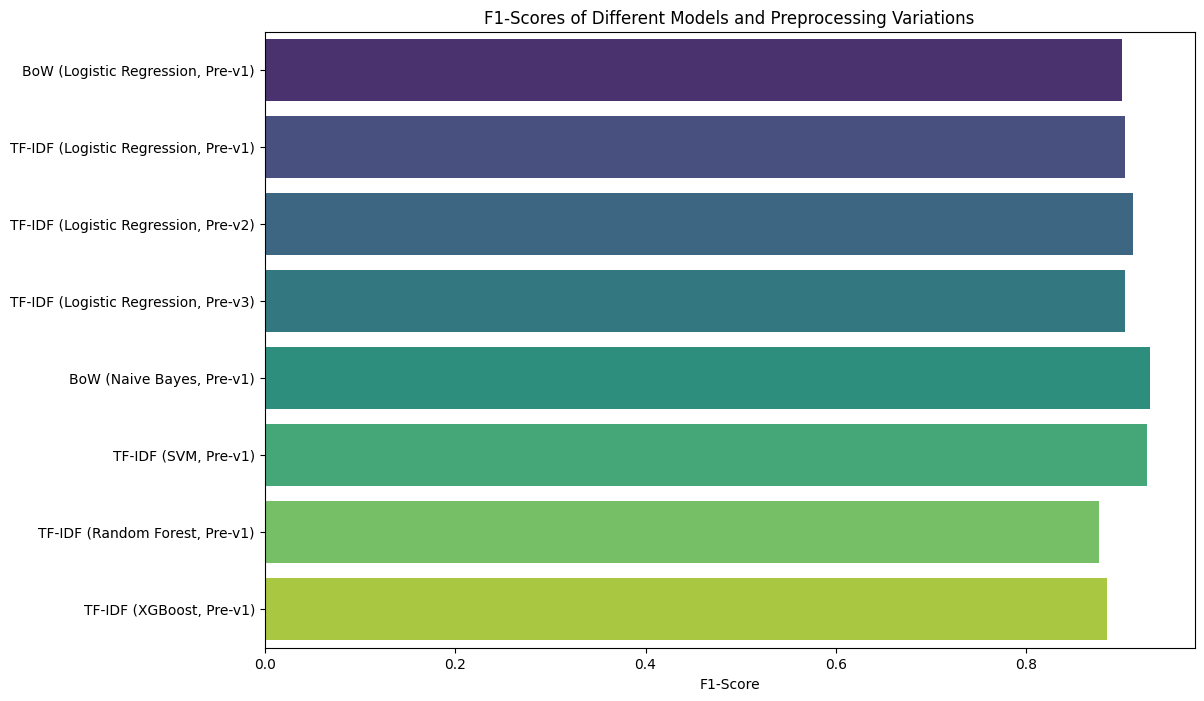

In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import seaborn as sns
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only label and text columns
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize stop words, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function to preprocess text for EDA
def preprocess_for_eda(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words]  # Keep alphanumeric
    return tokens

# Function to get n-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# EDA: Most frequent words, bigrams, trigrams
def perform_eda(df, class_label, class_name):
    class_texts = df[df['label'] == class_label]['text']
    all_tokens = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        all_tokens.extend(tokens)
    
    # Most frequent words
    word_counts = Counter(all_tokens)
    print(f"\nTop 10 words for {class_name}:")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")
    
    # Most frequent bigrams
    bigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        bigrams.extend(get_ngrams(tokens, 2))
    bigram_counts = Counter(bigrams)
    print(f"\nTop 10 bigrams for {class_name}:")
    for bigram, count in bigram_counts.most_common(10):
        print(f"{' '.join(bigram)}: {count}")
    
    # Most frequent trigrams
    trigrams = []
    for text in class_texts:
        tokens = preprocess_for_eda(text)
        trigrams.extend(get_ngrams(tokens, 3))
    trigram_counts = Counter(trigrams)
    print(f"\nTop 10 trigrams for {class_name}:")
    for trigram, count in trigram_counts.most_common(10):
        print(f"{' '.join(trigram)}: {count}")
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()

# Perform EDA for ham and spam
perform_eda(df, 0, 'Ham')
perform_eda(df, 1, 'Spam')

# Feature engineering: Extract message length and keyword presence
def extract_features(df):
    df['length'] = df['text'].apply(len)
    spam_keywords = ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']
    for keyword in spam_keywords:
        df[f'has_{keyword}'] = df['text'].str.lower().str.contains(keyword).astype(int)
    return df

df = extract_features(df)

# Split dataset
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing variations
def preprocess_text_v1(text):  # Keep ! and ?, lemmatization
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and (t.isalnum() or t in ['!', '?'])]
    return ' '.join(tokens)

def preprocess_text_v2(text):  # Keep all punctuation, lemmatization
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

def preprocess_text_v3(text):  # Keep ! and ?, stemming
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email IDs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and (t.isalnum() or t in ['!', '?'])]
    return ' '.join(tokens)

# Prepare features for all preprocessing variations
X_train_text_v1 = X_train['text'].apply(preprocess_text_v1)
X_test_text_v1 = X_test['text'].apply(preprocess_text_v1)
X_train_text_v2 = X_train['text'].apply(preprocess_text_v2)
X_test_text_v2 = X_test['text'].apply(preprocess_text_v2)
X_train_text_v3 = X_train['text'].apply(preprocess_text_v3)
X_test_text_v3 = X_test['text'].apply(preprocess_text_v3)

# Additional features (length and keywords)
additional_features = ['length'] + [f'has_{kw}' for kw in ['win', 'free', 'prize', 'claim', 'urgent', 'call', 'txt']]
X_train_additional = X_train[additional_features].values
X_test_additional = X_test[additional_features].values

# Scale additional features
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train_additional)
X_test_additional = scaler.transform(X_test_additional)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores, title):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialize results dictionary
f1_scores = {}
cv_scores = {}

# 1. Bag-of-Words with Logistic Regression (Preprocessing v1)
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train_text_v1)
X_test_bow = bow_vectorizer.transform(X_test_text_v1)
X_train_bow_combined = hstack([X_train_bow, X_train_additional])
X_test_bow_combined = hstack([X_test_bow, X_test_additional])

param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
grid_lr_bow = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_bow.fit(X_train_bow_combined, y_train)
y_pred_bow = grid_lr_bow.predict(X_test_bow_combined)
y_scores_bow = grid_lr_bow.predict_proba(X_test_bow_combined)[:, 1]
f1_bow = f1_score(y_test, y_pred_bow)
f1_scores['BoW (Logistic Regression, Pre-v1)'] = f1_bow
bow_cv_scores = cross_val_score(grid_lr_bow.best_estimator_, X_train_bow_combined, y_train, cv=5, scoring='f1')
cv_scores['BoW (Logistic Regression, Pre-v1)'] = (bow_cv_scores.mean(), bow_cv_scores.std())
print(f"\nF1-score for BoW (Logistic Regression, Pre-v1): {f1_bow:.4f}")
print(f"Cross-validation F1-scores: {bow_cv_scores.mean():.4f} ± {bow_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_bow, 'BoW (Logistic Regression, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_bow, 'BoW (Logistic Regression, Pre-v1)')

# 2. TF-IDF with Logistic Regression (Preprocessing v1)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_v1 = tfidf_vectorizer.fit_transform(X_train_text_v1)
X_test_tfidf_v1 = tfidf_vectorizer.transform(X_test_text_v1)
X_train_tfidf_v1_combined = hstack([X_train_tfidf_v1, X_train_additional])
X_test_tfidf_v1_combined = hstack([X_test_tfidf_v1, X_test_additional])

grid_lr_tfidf_v1 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v1.fit(X_train_tfidf_v1_combined, y_train)
y_pred_tfidf_v1 = grid_lr_tfidf_v1.predict(X_test_tfidf_v1_combined)
y_scores_tfidf_v1 = grid_lr_tfidf_v1.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_tfidf_v1 = f1_score(y_test, y_pred_tfidf_v1)
f1_scores['TF-IDF (Logistic Regression, Pre-v1)'] = f1_tfidf_v1
tfidf_v1_cv_scores = cross_val_score(grid_lr_tfidf_v1.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v1)'] = (tfidf_v1_cv_scores.mean(), tfidf_v1_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v1): {f1_tfidf_v1:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v1_cv_scores.mean():.4f} ± {tfidf_v1_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v1, 'TF-IDF (Logistic Regression, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v1, 'TF-IDF (Logistic Regression, Pre-v1)')

# 3. TF-IDF with Logistic Regression (Preprocessing v2: Keep all punctuation)
X_train_tfidf_v2 = tfidf_vectorizer.fit_transform(X_train_text_v2)
X_test_tfidf_v2 = tfidf_vectorizer.transform(X_test_text_v2)
X_train_tfidf_v2_combined = hstack([X_train_tfidf_v2, X_train_additional])
X_test_tfidf_v2_combined = hstack([X_test_tfidf_v2, X_test_additional])

grid_lr_tfidf_v2 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v2.fit(X_train_tfidf_v2_combined, y_train)
y_pred_tfidf_v2 = grid_lr_tfidf_v2.predict(X_test_tfidf_v2_combined)
y_scores_tfidf_v2 = grid_lr_tfidf_v2.predict_proba(X_test_tfidf_v2_combined)[:, 1]
f1_tfidf_v2 = f1_score(y_test, y_pred_tfidf_v2)
f1_scores['TF-IDF (Logistic Regression, Pre-v2)'] = f1_tfidf_v2
tfidf_v2_cv_scores = cross_val_score(grid_lr_tfidf_v2.best_estimator_, X_train_tfidf_v2_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v2)'] = (tfidf_v2_cv_scores.mean(), tfidf_v2_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v2): {f1_tfidf_v2:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v2_cv_scores.mean():.4f} ± {tfidf_v2_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v2, 'TF-IDF (Logistic Regression, Pre-v2)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v2, 'TF-IDF (Logistic Regression, Pre-v2)')

# 4. TF-IDF with Logistic Regression (Preprocessing v3: Stemming)
X_train_tfidf_v3 = tfidf_vectorizer.fit_transform(X_train_text_v3)
X_test_tfidf_v3 = tfidf_vectorizer.transform(X_test_text_v3)
X_train_tfidf_v3_combined = hstack([X_train_tfidf_v3, X_train_additional])
X_test_tfidf_v3_combined = hstack([X_test_tfidf_v3, X_test_additional])

grid_lr_tfidf_v3 = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr_tfidf_v3.fit(X_train_tfidf_v3_combined, y_train)
y_pred_tfidf_v3 = grid_lr_tfidf_v3.predict(X_test_tfidf_v3_combined)
y_scores_tfidf_v3 = grid_lr_tfidf_v3.predict_proba(X_test_tfidf_v3_combined)[:, 1]
f1_tfidf_v3 = f1_score(y_test, y_pred_tfidf_v3)
f1_scores['TF-IDF (Logistic Regression, Pre-v3)'] = f1_tfidf_v3
tfidf_v3_cv_scores = cross_val_score(grid_lr_tfidf_v3.best_estimator_, X_train_tfidf_v3_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Logistic Regression, Pre-v3)'] = (tfidf_v3_cv_scores.mean(), tfidf_v3_cv_scores.std())
print(f"F1-score for TF-IDF (Logistic Regression, Pre-v3): {f1_tfidf_v3:.4f}")
print(f"Cross-validation F1-scores: {tfidf_v3_cv_scores.mean():.4f} ± {tfidf_v3_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_tfidf_v3, 'TF-IDF (Logistic Regression, Pre-v3)')
plot_precision_recall_curve(y_test, y_scores_tfidf_v3, 'TF-IDF (Logistic Regression, Pre-v3)')

# 5. Naive Bayes with BoW (Preprocessing v1)
nb = MultinomialNB()
X_train_additional_nb = scaler.fit_transform(X_train[additional_features].values)
X_train_additional_nb = (X_train_additional_nb - X_train_additional_nb.min()) / (X_train_additional_nb.max() - X_train_additional_nb.min())
X_test_additional_nb = scaler.transform(X_test[additional_features].values)
X_test_additional_nb = (X_test_additional_nb - X_test_additional_nb.min()) / (X_test_additional_nb.max() - X_test_additional_nb.min())
X_train_bow_nb = hstack([X_train_bow, X_train_additional_nb])
X_test_bow_nb = hstack([X_test_bow, X_test_additional_nb])
nb.fit(X_train_bow_nb, y_train)
y_pred_nb = nb.predict(X_test_bow_nb)
y_scores_nb = nb.predict_proba(X_test_bow_nb)[:, 1]
f1_nb = f1_score(y_test, y_pred_nb)
f1_scores['BoW (Naive Bayes, Pre-v1)'] = f1_nb
nb_cv_scores = cross_val_score(nb, X_train_bow_nb, y_train, cv=5, scoring='f1')
cv_scores['BoW (Naive Bayes, Pre-v1)'] = (nb_cv_scores.mean(), nb_cv_scores.std())
print(f"F1-score for BoW (Naive Bayes, Pre-v1): {f1_nb:.4f}")
print(f"Cross-validation F1-scores: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_nb, 'BoW (Naive Bayes, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_nb, 'BoW (Naive Bayes, Pre-v1)')

# 6. SVM with TF-IDF (Preprocessing v1)
svm = LinearSVC(random_state=42)
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100]}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_tfidf_v1_combined, y_train)
y_pred_svm = grid_svm.predict(X_test_tfidf_v1_combined)
y_scores_svm = grid_svm.decision_function(X_test_tfidf_v1_combined)
f1_svm = f1_score(y_test, y_pred_svm)
f1_scores['TF-IDF (SVM, Pre-v1)'] = f1_svm
svm_cv_scores = cross_val_score(grid_svm.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (SVM, Pre-v1)'] = (svm_cv_scores.mean(), svm_cv_scores.std())
print(f"F1-score for TF-IDF (SVM, Pre-v1): {f1_svm:.4f}")
print(f"Cross-validation F1-scores: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_svm, 'TF-IDF (SVM, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_svm, 'TF-IDF (SVM, Pre-v1)')

# 7. Random Forest with TF-IDF (Preprocessing v1)
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_tfidf_v1_combined, y_train)
y_pred_rf = grid_rf.predict(X_test_tfidf_v1_combined)
y_scores_rf = grid_rf.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_rf = f1_score(y_test, y_pred_rf)
f1_scores['TF-IDF (Random Forest, Pre-v1)'] = f1_rf
rf_cv_scores = cross_val_score(grid_rf.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (Random Forest, Pre-v1)'] = (rf_cv_scores.mean(), rf_cv_scores.std())
print(f"F1-score for TF-IDF (Random Forest, Pre-v1): {f1_rf:.4f}")
print(f"Cross-validation F1-scores: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_rf, 'TF-IDF (Random Forest, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_rf, 'TF-IDF (Random Forest, Pre-v1)')

# 8. XGBoost with TF-IDF (Preprocessing v1)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6, 10]}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_tfidf_v1_combined, y_train)
y_pred_xgb = grid_xgb.predict(X_test_tfidf_v1_combined)
y_scores_xgb = grid_xgb.predict_proba(X_test_tfidf_v1_combined)[:, 1]
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_scores['TF-IDF (XGBoost, Pre-v1)'] = f1_xgb
xgb_cv_scores = cross_val_score(grid_xgb.best_estimator_, X_train_tfidf_v1_combined, y_train, cv=5, scoring='f1')
cv_scores['TF-IDF (XGBoost, Pre-v1)'] = (xgb_cv_scores.mean(), xgb_cv_scores.std())
print(f"F1-score for TF-IDF (XGBoost, Pre-v1): {f1_xgb:.4f}")
print(f"Cross-validation F1-scores: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")
plot_confusion_matrix(y_test, y_pred_xgb, 'TF-IDF (XGBoost, Pre-v1)')
plot_precision_recall_curve(y_test, y_scores_xgb, 'TF-IDF (XGBoost, Pre-v1)')

# Summary of F1-scores
print("\nSummary of F1-scores:")
for method, score in f1_scores.items():
    print(f"{method}: {score:.4f}")
print("\nSummary of Cross-validation F1-scores (Mean ± Std):")
for method, (mean, std) in cv_scores.items():
    print(f"{method}: {mean:.4f} ± {std:.4f}")

# Visualize F1-scores
plt.figure(figsize=(12, 8))
sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis')
plt.xlabel('F1-Score')
plt.title('F1-Scores of Different Models and Preprocessing Variations')
plt.show()